In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data For Good - Tax Observatory Dataviz

Visualizations for the EU Tax Observatory based on the [EU Tax Obs - Dataviz - Viz](https://docs.google.com/document/d/1q_7x8NrEWNsak9LSE3TxIiSphhVcqWqn6YeG1kQNQTk/edit#heading=h.97g77izer615) Google Docs.

## Table of contents
* [Initialization](#initialization)
* [#12 - available reports by company](#12---available-reports-by-company)
* [#13 - company key financials kpis](#13---company-key-financials-kpis)
* [#14 - company top jurisdictions for revenue](#14---company-top-jurisdictions-for-revenue)

## Initialization

In [381]:
# Import dataset in a DataFrame
df = pd.read_csv('data_final_dataviz.csv', sep=',')

In the website it will be possible to select a specific company. To work on the viz creation, we simulate the selection by picking a random company but also a random year.

In [382]:
# Select a random company and a random year
def pick_random_company_and_year() -> tuple:
    company = np.random.choice(df['mnc'].unique())
    print(f'Selected company : {company}.')

    year = np.random.choice(df.loc[df['mnc'] == company, 'year'].unique())
    print(f'Selected year : {year}.')

    return company, year

In [383]:
company, year = pick_random_company_and_year()
# company, year = 'SHELL', 2020

Selected company : ACCIONA.
Selected year : 2020.


## #12 - available reports by company

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|tbd (goal is on company page, to show reports tracked, so could be just a table showing year available for a company)|-||`company explo` need a filter by company||

In [384]:
# Display number of reports per year in a table
print(f'Number of reports per year for {company}')
df.loc[df['mnc'] == company, 'year'].value_counts().reset_index()

Number of reports per year for ACCIONA


,year,count
0,2022,12
1,2020,11
2,2021,11


In [385]:
# Display number of empty/not empty reports per year in a table
print(f'Number of empty/not empty reports per year for {company}')
df.loc[df['mnc'] == company].groupby('year')['empty'].value_counts().reset_index(level='year')

Number of empty/not empty reports per year for ACCIONA


,year,count
empty,,
False,2020,11
False,2021,11
False,2022,12


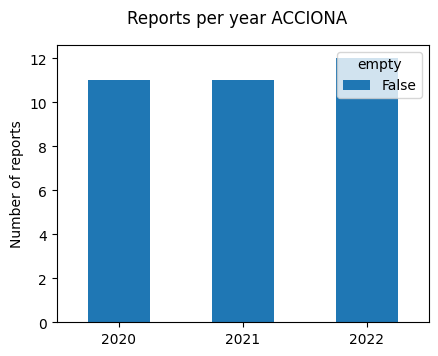

In [386]:
# Display number of empty/not empty reports per year in a bar plot
fig, ax = plt.subplots(figsize=(4.8, 3.6))
df.loc[df['mnc'] == company].groupby('year')['empty'].value_counts().unstack(level='empty').plot.bar(ax=ax)
ax.tick_params(axis='x', labelrotation = 0)
ax.set_xlabel('')
ax.set_ylabel('Number of reports')
fig.suptitle(f'Reports per year {company}')
plt.show()

## #13 - company key financials kpis

**kpis** : hq country, total revenue, total unrelated party revenues, total related party revenues, pre-tax profits, taxes paid, employees.

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|raw figure for each, or table with indicator name in col A, value in col B|hq country : -<br><br>metrics : sum (metric) by year by mnc|**giulia : keep all values, even negative values**|`company explo` need a filter by company||

In [387]:
# List financial kpis
kpis_list = ['total_revenues', 'unrelated_revenues', 'related_revenues', 
             'profit_before_tax', 'tax_paid', 'employees']

In [388]:
# Display kpis value per year in a table
df.loc[df['mnc'] == company].groupby(['year', 'upe_code'])[kpis_list].sum().reset_index(level='upe_code').T

year,2020,2021,2022
upe_code,ESP,ESP,ESP
total_revenues,6471000000.0,8105000000.0,11189000000.0
unrelated_revenues,0.0,0.0,0.0
related_revenues,0.0,0.0,0.0
profit_before_tax,509000000.0,574000000.0,868000000.0
tax_paid,44600000.0,82200000.0,213850000.0
employees,38355.0,41662.0,45892.0


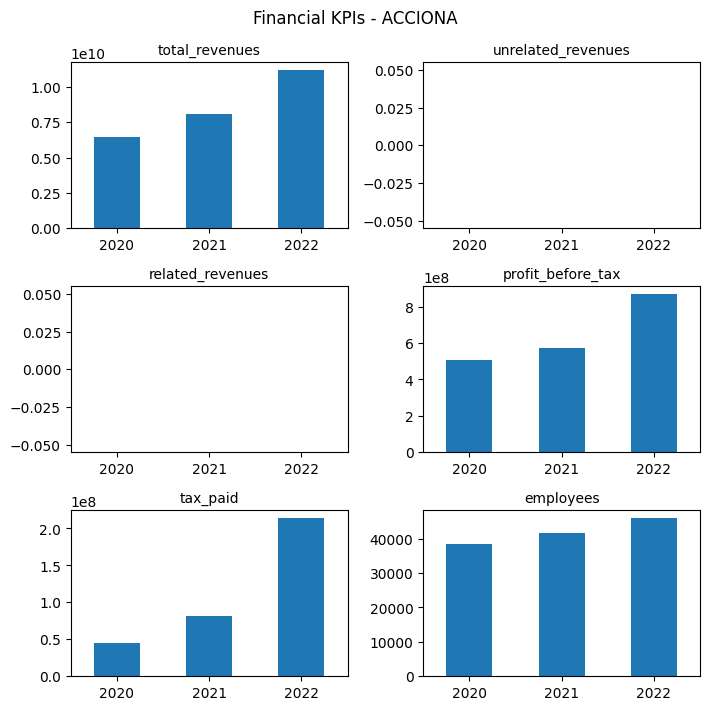

In [389]:
# Display kpis value per year in barplots
fig, axs = plt.subplots(3, 2, figsize=(7.2, 7.2))
for i, kpi in enumerate(kpis_list):
    r = i // 2
    c = i % 2
    df.loc[df['mnc'] == company].groupby(['year'])[kpi].sum().to_frame().plot.bar(ax=axs[r, c])
    axs[r, c].set_title(kpi, size=10)
    axs[r, c].tick_params(axis='x', labelrotation = 0)
    axs[r, c].set_xlabel('')
    axs[r, c].legend().set_visible(False)

# Delete empty subplots
# [fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]

fig.suptitle(f'Financial KPIs - {company}')

plt.tight_layout()
plt.show()

## #14 - company top jurisdictions for revenue

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|horizontal bar chart showing % total revenue for top 9 jurisdictions + rest as “OTHERS”|sum(revenue) by company x hq country x year, display top 9 and group remaining countries||`company explo` need a filter by company||

In [390]:
def compute_top_jurisdictions_revenue(df:pd.DataFrame, company:str, year:int) -> pd.DataFrame:
    df = df.loc[(df['mnc'] == company) & (df['year'] == year), ['jur_name', 'total_revenues']]
    df = df.fillna(0)
    df = df.sort_values(by='total_revenues', ascending=False)

    top = df.nlargest(9, 'total_revenues').reset_index(drop=True)
    
    n_rows=len(df.index)
    others = df.iloc[9:n_rows]['total_revenues'].sum()
    top.loc[len(top.index)] = ['Others', others]

    top['%_total_revenues'] = top['total_revenues'] / top['total_revenues'].sum() * 100
    

    return top.sort_values(by='total_revenues')

In [391]:
top = compute_top_jurisdictions_revenue(df=df, company=company, year=year)
top

,jur_name,total_revenues,%_total_revenues
9,Others,5.600000e+07,0.865399
8,United States of America,7.100000e+07,1.097203
7,Portugal,1.520000e+08,2.348941
6,Mexico,2.380000e+08,3.677948
5,Canada,3.270000e+08,5.053315
4,Saudi Arabia,3.290000e+08,5.084222
3,Poland,3.350000e+08,5.176943
2,Australia,8.810000e+08,13.614588
1,Other,1.409000e+09,21.774069
0,Spain,2.673000e+09,41.307371


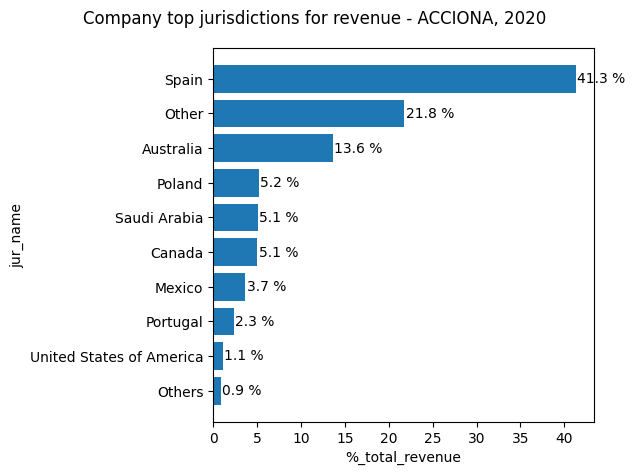

In [392]:
def plot_jurisdictions_top_revenue(top: pd.DataFrame):

    fig, ax = plt.subplots()
    bar = ax.barh(y=top['jur_name'], width=top['%_total_revenues'])

    ax.bar_label(bar, fmt='{:.1f} %', padding=1)

    ax.tick_params(axis='x', rotation=0)
    ax.set_xlabel('%_total_revenue')
    ax.set_ylabel('jur_name')

    fig.suptitle(f'Company top jurisdictions for revenue - {company}, {year}')

    plt.tight_layout()
    plt.show()

plot_jurisdictions_top_revenue(top=top)

## #15 - company’s % pre-tax profit and % employees by jurisdiction

|viz|how to compute|how to manage negative values|where / variant needed|comment|
|-|-|-|-|-|
|horizontal bar chart with one bar for % pre tax profit, the other for % employees, in different colors rank by % pre-tax profit descending|for a company : filter (profit >0) profits by JUR / total profit vs employees by JUR / total employees|**giulia : keep only positive values**|`company explo` need a filter by company||

In [393]:
def compute_pretax_profit_and_employees_rank(df:pd.DataFrame, company:str, year:int) -> pd.DataFrame:
    df = df.loc[
        (df['mnc'] == company) & (df['year'] == year) & (df['profit_before_tax'] > 0), 
        ['jur_name', 'profit_before_tax', 'employees']
    ]

    df = df.fillna(0)

    df['%_profit_before_tax'] = df['profit_before_tax'] / df['profit_before_tax'].sum() * 100
    df['%_employees'] = df['employees'] / df['employees'].sum() * 100

    return df.sort_values(by='profit_before_tax', ascending=True)

In [394]:
rank = compute_pretax_profit_and_employees_rank(df, company, year)
rank

,jur_name,profit_before_tax,employees,%_profit_before_tax,%_employees
6,Portugal,9000000.0,2015.0,1.495017,5.535410
5,Saudi Arabia,10000000.0,131.0,1.661130,0.359870
4,Poland,19000000.0,1523.0,3.156146,4.183836
3,Australia,33000000.0,1704.0,5.481728,4.681061
10,Other,35000000.0,7763.0,5.813953,21.325751
2,Mexico,54000000.0,1978.0,8.970100,5.433767
1,Germany,75000000.0,428.0,12.458472,1.175760
0,Spain,367000000.0,20860.0,60.963455,57.304544


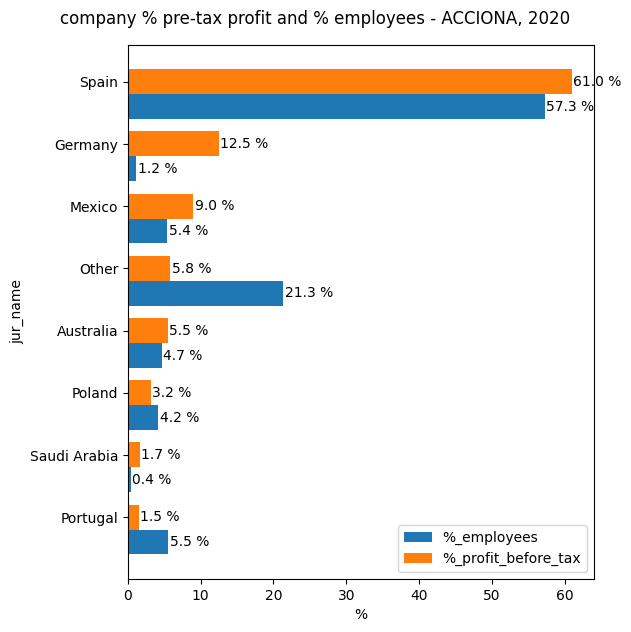

In [396]:
def plot_pretax_profit_and_employees_rank(rank: pd.DataFrame):
    jurisdictions = rank['jur_name'].values
    bar_width = 0.4
    bar_offsets = [-bar_width, 0, bar_width]

    fig, ax = plt.subplots(figsize=(6.4, 6.4))

    for i, (column, values) in enumerate(rank[['%_employees', '%_profit_before_tax']].items()):
        bar_positions = []
        for j in range(len(jurisdictions)):
            bar_positions.append(j + bar_offsets[i])
        bars = ax.barh(bar_positions, values, height=bar_width, label=column)
        ax.bar_label(bars, fmt='{:.1f} %', padding=1)

    ax.set_xlabel('%')
    ax.set_yticks(range(len(jurisdictions)))
    ax.set_yticklabels(jurisdictions)
    ax.set_ylabel('jur_name')
    ax.legend()
    # ax.set_xscale('log')

    fig.suptitle(f'company % pre-tax profit and % employees - {company}, {year}')

    plt.tight_layout()
    plt.show()

plot_pretax_profit_and_employees_rank(rank=rank)